In [2]:
import numpy as np
import struct
import matplotlib.pyplot as plt

with open('/Users/lydia22/Desktop/Junior/482HW3/train-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    print(data.shape)
    Xtraindata = np.transpose(data.reshape((size, nrows*ncols)))

with open('/Users/lydia22/Desktop/Junior/482HW3/train-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    ytrainlabels = data.reshape((size,)) # (Optional)

with open('/Users/lydia22/Desktop/Junior/482HW3/t10k-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    Xtestdata = np.transpose(data.reshape((size, nrows*ncols)))

with open('/Users/lydia22/Desktop/Junior/482HW3/t10k-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    ytestlabels = data.reshape((size,)) # (Optional)
        

    
traindata_imgs =  np.transpose(Xtraindata).reshape((60000,28,28))    
print(Xtraindata.shape)
print(ytrainlabels.shape)
print(Xtestdata.shape)
print(ytestlabels.shape)

(47040000,)
(784, 60000)
(60000,)
(784, 10000)
(10000,)


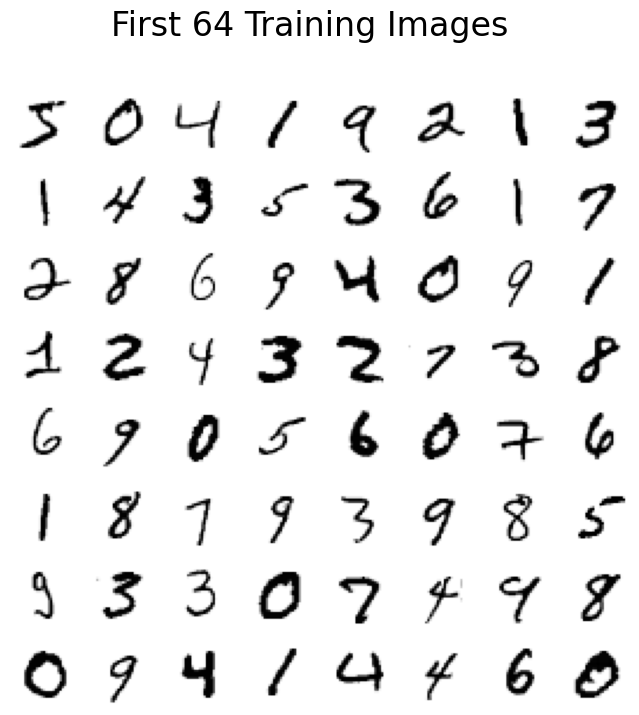

In [3]:
def plot_digits(XX, N, title):
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    
    for i in range(N):
      for j in range(N):
        ax[i,j].imshow(XX[:,(N)*i+j].reshape((28, 28)), cmap="Greys")
        ax[i,j].axis("off")
    fig.suptitle(title, fontsize=24)

plot_digits(Xtraindata, 8, "First 64 Training Images" )


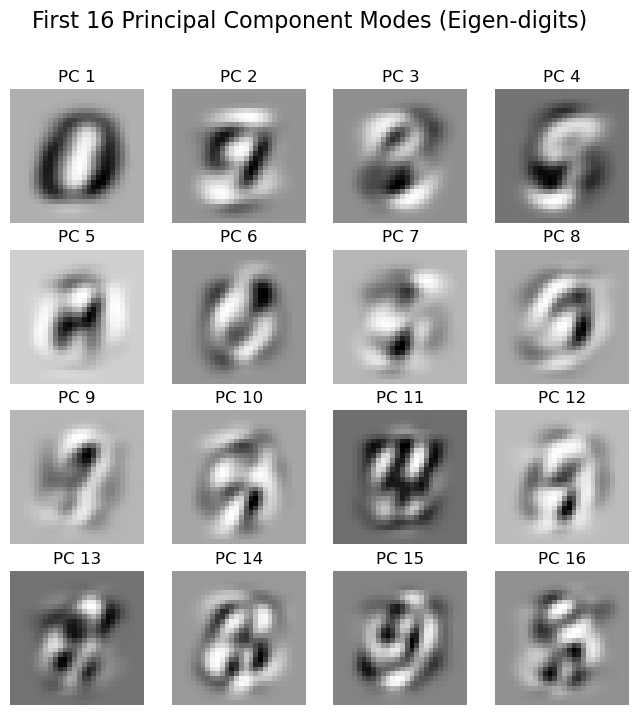

In [8]:
from sklearn.decomposition import PCA
Xtrain = Xtraindata.T  # shape -> (60000, 784)
Xtest  = Xtestdata.T   # shape -> (10000, 784)
#task 1
pca = PCA() 
pca.fit(Xtrain) 
first16 = pca.components_[:16, :] #first 16 pc modes

fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(28, 28), cmap="Greys")
    ax.axis("off")
    ax.set_title(f"PC {i+1}")

plt.suptitle("First 16 Principal Component Modes")
plt.show()

Number of components to reach 85% variance: k = 59


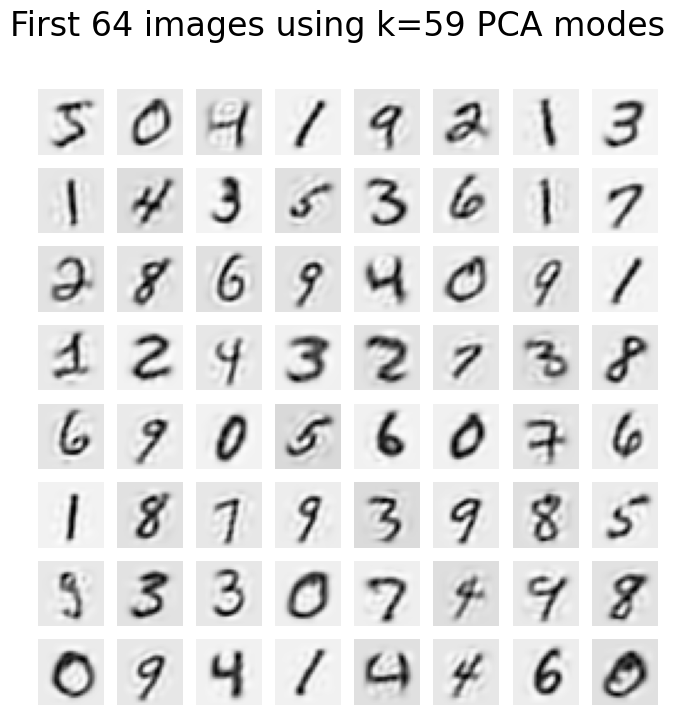

In [11]:
#task 2
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

k_85 = np.where(cumulative_variance >= 0.85)[0][0] + 1
#[0] [0] represent the first index that cumulative variance is greater than 0.85
print(f"Number of components to reach 85% variance: k = {k_85}")

pca_k = PCA(n_components=k_85)
pca_k.fit(Xtrain) 

Xtrain_reduced = pca_k.transform(Xtrain)        # shape -> (60000, k_85)
Xtrain_recon   = pca_k.inverse_transform(Xtrain_reduced)  # shape -> (60000, 784)

# Plot the first 64 image
plot_digits(Xtrain_recon[:64].T, 8, 
            f"First 64 images using k={k_85} PCA modes")


In [28]:
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

Task 3: Try to create a way that isolate only the samples that belong to particular digit classes from 1 and 8 
1. create a boolen mask for the training labels to identify which rows correspond to the desired digits 
2. use this mask to slice out only the relevant rows of X train and Y train data 
3. repeat the same process for x test and y test

In [35]:
# Project on PCA of x train is in task 2
Xtest_reduced = pca_k.transform(Xtest) 

In [36]:
def digit(Xtrain, ytrain, Xtext, ytest, digits):
    train_mask = np.isin(ytrain, digits)
    #y data are the outputs, so we want to mask based on the values of y (labels)
    test_mask = np.isin(ytest, digits)
    
    xsub_train = Xtrain_reduced[train_mask,:]#filter rows of xtrain based on the train mask
    # select only rows where train_mask is true
    xsub_test = Xtest_reduced[test_mask,:]
    ysub_train = ytrain[train_mask]
    ysub_test = ytest[test_mask]
    return xsub_train, ysub_train, xsub_test, ysub_test

Task 4: Use a linear classifier (RidgeClassifier in sklearn.linear_model) to distinguish between digit 1 and 8 
1. project onto PCA, use the trained PCA to transform the subdataset. 
(PCA) is used here to reduce the dimensionality of the dataset while preserving 85% of the variance. 
2. train a ridge classigier on the training subset (1,8)
3. cross validation = reduce the overfittign and gives a more reliable accuracy estimate 
(instead of single test split, we average multiple evaluations)
4. After choosing the models, refit on the entire training subset and measure the accuracy 

In [37]:
def two_digit(digit1, digit2, xtrain_full, ytrain_full, xtest_full, ytest_full):
    #use the digit function to mask out the for digit 
    Xsub_train, ysub_train, Xsub_test, ysub_test = digit(
    xtrain_full, ytrain_full, xtest_full, ytest_full, digits=[digit1, digit2])
    #train the ridge classifier 
    clf = RidgeClassifier()
    #Cross validation on training subset
    #cross_val_score()come from sklearn.model_selection that automate cross validation 
    # and return the performance scores
    cv_scores = cross_val_score(clf, Xsub_train, ysub_train, cv=5)
    mean_cv_acc = cv_scores.mean()
    std_cv_acc = cv_scores.std()
    print(f"{digit1} vs {digit2}: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
    # the classifier achieves % of accuracy +- the standard deviation
    clf.fit(Xsub_train, ysub_train)
    # clffit is the method that used to train the classifier 
    # it learns from the xsubtrain and how they are labeled to ysubtrain
    test_acc = clf.score(Xsub_test, ysub_test)
    #accuracy = correct predictions/ total predictions
    print(f"Digits{digit1} vs {digit2}: Test_accuracy = {test_acc:.4f}\n")
    return mean_cv_acc, std_cv_acc, test_acc

In [38]:
#task 5: put the digits into the two-digit function
results = {}
digitpairs = [(1, 8), (3, 8), (2, 7)]
for digit1, digit2 in digitpairs: 
    results[(digit1, digit2)] = two_digit(digit1, digit2,Xtrain_reduced, ytrainlabels, Xtest_reduced, ytestlabels)
for (digit1, digit2), (mean_cv, std_cv, test_acc) in results.items():
    print(f" {digit1} vs {digit2}  |  {mean_cv:.2f} ± {std_cv:.2f}  |  {test_acc:.2f}")

1 vs 8: 0.9642 ± 0.0025
Digits1 vs 8: Test_accuracy = 0.9801

3 vs 8: 0.9589 ± 0.0062
Digits3 vs 8: Test_accuracy = 0.9642

2 vs 7: 0.9799 ± 0.0019
Digits2 vs 7: Test_accuracy = 0.9743

 1 vs 8  |  0.9642 ± 0.0025  |  0.9801
 3 vs 8  |  0.9589 ± 0.0062  |  0.9642
 2 vs 7  |  0.9799 ± 0.0019  |  0.9743


#Task 6: 
Instead of only focusing on 2 digits, classify all 10 digits. 
Compare a Ridge Approach and a K-Nearest Neighbors approach 
1. initialize the Ridge Classifier 
2. Perform cross validation on the entire training set 
3. refit on the entire training data 
4. compute the predictions on the entire test 
5. compute the test accuracy 
(the above steps are the similar thing for the 1,8 selection)
(the following applied KNN classifier)
1. initialize a KN classifier 
2. perform cv 
3. refit the entire training data 
4. compare 

In [47]:
# initialize the ridge classifier 
clf = RidgeClassifier()
# perform the cv 
cv_rscores = cross_val_score(clf, Xtrain_reduced, ytrainlabels, cv=5)
#refit 
clf.fit(Xtrain_reduced, ytrainlabels)
#compute the predictions
ypredtest_clf = clf.predict(Xtest_reduced)
clf_acc = accuracy_score(ytestlabels, ypredtest_clf)
print(f"Ridge Classifier multi-class accuracy: {clf_acc:.4f}")

Ridge Classifier multi-class accuracy: 0.8560


In [43]:
# initialize the ridge classifier 
knn_clf = KNeighborsClassifier(n_neighbors=5)
# perform the cv 
cv_kscores = cross_val_score(knn_clf, Xtrain_reduced, ytrainlabels, cv=5)
#refit 
knn_clf.fit(Xtrain_reduced, ytrainlabels)
#compute the predictions
ypredtest_knn = knn_clf.predict(Xtest_reduced)
knn_clf_acc = accuracy_score(ytestlabels, ypredtest_knn)
print(f"Knn Classifier multi-class accuracy: {knn_clf_acc:.4f}")

/Users/lydia22/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/lydia22/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

Knn Classifier multi-class accuracy: 0.9758


/Users/lydia22/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [45]:
print(f"KNN multi-class CV accuracy: {cv_kscores.mean():.4f} ± {cv_kscores.std():.4f}")

KNN multi-class CV accuracy: 0.9747 ± 0.0013


In [48]:
print(f"Ridge multi-class CV accuracy: {cv_rscores.mean():.4f} ± {cv_rscores.std():.4f}")

Ridge multi-class CV accuracy: 0.8439 ± 0.0096


In [50]:
#Task 7
from sklearn.svm import SVC 
from sklearn.model_selection import cross_val_score
svc_clf = SVC()
svc_cv_scores = cross_val_score(svc_clf, Xtrain_reduced, ytrainlabels, cv=5)
print(f"SVC multi-class CV accuracy: {svc_cv_scores.mean():.4f} ± {svc_cv_scores.std():.4f}")

SVC multi-class CV accuracy: 0.9812 ± 0.0016


In [51]:
#refit 
svc_clf.fit(Xtrain_reduced, ytrainlabels)
ypredtest_scv = svc_clf.predict(Xtest_reduced)
svc_acc = accuracy_score(ytestlabels, ypredtest_scv)

In [52]:
print(f"SVC Classifier multi-class accuracy: {svc_acc:.4f}")

SVC Classifier multi-class accuracy: 0.9841
